In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, Normalizer, StandardScaler
from sklearn import model_selection, tree, neighbors, metrics, ensemble
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.decomposition import PCA

In [9]:
df_train= pd.read_csv('LFTS_train/train.csv')
df_test= pd.read_csv('LFTS_test.csv')

In [10]:
df_train['Employment.Type'].fillna(df_train['Employment.Type'].dropna().max(), inplace=True)
df_test['Employment.Type'].fillna(df_test['Employment.Type'].dropna().max(), inplace=True)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233154 entries, 0 to 233153
Data columns (total 41 columns):
UniqueID                               233154 non-null int64
disbursed_amount                       233154 non-null int64
asset_cost                             233154 non-null int64
ltv                                    233154 non-null float64
branch_id                              233154 non-null int64
supplier_id                            233154 non-null int64
manufacturer_id                        233154 non-null int64
Current_pincode_ID                     233154 non-null int64
Date.of.Birth                          233154 non-null object
Employment.Type                        233154 non-null object
DisbursalDate                          233154 non-null object
State_ID                               233154 non-null int64
Employee_code_ID                       233154 non-null int64
MobileNo_Avl_Flag                      233154 non-null int64
Aadhar_flag                   

In [12]:
train=df_train.drop(['UniqueID','Date.of.Birth','DisbursalDate','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'], axis=1)
test=df_test.drop(['UniqueID','Date.of.Birth','DisbursalDate','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'], axis=1)

In [13]:
train.head()

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Employment.Type,State_ID,Employee_code_ID,...,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default
0,50578,58400,89.55,67,22807,45,1441,Salaried,6,1998,...,0,0,0,0,0,0,0,0,0,0
1,47145,65550,73.23,67,22807,45,1502,Self employed,6,1998,...,0,0,0,0,1991,0,0,1,0,1
2,53278,61360,89.63,67,22807,45,1497,Self employed,6,1998,...,0,0,0,0,0,0,0,0,0,0
3,57513,66113,88.48,67,22807,45,1501,Self employed,6,1998,...,0,0,0,0,31,0,0,0,1,1
4,52378,60300,88.39,67,22807,45,1495,Self employed,6,1998,...,0,0,0,0,0,0,0,0,1,1


In [14]:
le=LabelEncoder()
col=['PERFORM_CNS.SCORE.DESCRIPTION', 'Employment.Type', 'Employee_code_ID','branch_id','supplier_id','manufacturer_id','Current_pincode_ID']
for c in col:
    train[c]=le.fit_transform(train[c])
    test[c]=le.fit_transform(test[c])

0: 182543
1: 50611


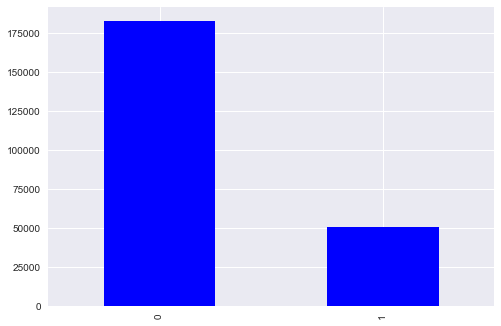

In [15]:
#apply resampling
target_count= train['loan_default'].value_counts()
target_count.plot(kind='bar')
print('0:',target_count[0])
print('1:',target_count[1])
plt.show()

In [16]:
count_0, count_1=train['loan_default'].value_counts()
train_0=train[train['loan_default']==0]
train_1=train[train['loan_default']==1]

In [17]:
df_under=train_0.sample(count_1)
df_under=pd.concat([df_under, train_1], axis=0)
df_under['loan_default'].value_counts()

1    50611
0    50611
Name: loan_default, dtype: int64

In [18]:
df_over=train_1.sample(count_0, replace=True)
df_over=pd.concat([df_over,train_0], axis=0)
df_over['loan_default'].value_counts()

1    182543
0    182543
Name: loan_default, dtype: int64

In [19]:
y_over=df_over['loan_default']
x_over=df_over.drop('loan_default', axis=1)
y_under=df_under['loan_default']
x_under=df_under.drop('loan_default', axis=1)

In [20]:
x_under.shape

(101222, 35)

In [21]:
#standard scaler on x and test
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(x_under)
# Apply transform to both the training set and the test set.
x_scale= scaler.transform(x_under)
# x_over_scale= scaler.transform(x_over)
test = scaler.transform(test)

/Users/gagicha/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/gagicha/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/Users/gagicha/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [22]:
#pca
pca = PCA(.95)
pca.fit(x_scale)
x_pca = pca.transform(x_scale)
test = pca.transform(test)

In [23]:
pca.n_components_

24

so from 35 columns, pca transformed data to 24 columns.

In [24]:
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout

In [44]:
def classifier(weights_path=None):    
    model= Sequential()# this just means adding one layer at a time
    model.add(Dense(15, input_dim=24, kernel_initializer='normal', activation='relu'))# dense layer is fully connected neural network layer
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))# dense layer is fully connected neural network layer
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    return model

In [45]:
nn=classifier()

In [48]:
nn.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [49]:
nn.fit(x_pca, y_under, validation_split=0.3, epochs=20, batch_size=32)

Train on 70855 samples, validate on 30367 samples
Epoch 1/20
70855/70855 [==============================] - 2s 34us/step - loss: 0.4728 - acc: 0.7340 - val_loss: 4.7648 - val_acc: 0.0737
Epoch 2/20
70855/70855 [==============================] - 2s 31us/step - loss: 0.4725 - acc: 0.7342 - val_loss: 5.0293 - val_acc: 0.0558
Epoch 3/20
70855/70855 [==============================] - 2s 32us/step - loss: 0.4724 - acc: 0.7343 - val_loss: 4.8744 - val_acc: 0.0842
Epoch 4/20
70855/70855 [==============================] - 2s 32us/step - loss: 0.4723 - acc: 0.7355 - val_loss: 4.9779 - val_acc: 0.0695
Epoch 5/20
70855/70855 [==============================] - 2s 33us/step - loss: 0.4720 - acc: 0.7334 - val_loss: 5.1685 - val_acc: 0.0523
Epoch 6/20
70855/70855 [==============================] - 2s 32us/step - loss: 0.4722 - acc: 0.7347 - val_loss: 5.0381 - val_acc: 0.0732
Epoch 7/20
70855/70855 [==============================] - 2s 31us/step - loss: 0.4719 - acc: 0.7353 - val_loss: 5.0213 - val_acc

In [39]:
y_hat = nn.predict(test, batch_size=32)
y_pred = np.argmax(y_hat,axis=1)

In [40]:
out=pd.concat([df_test['UniqueID'], pd.DataFrame(y_pred, columns=['loan_default'])], axis=1)

In [41]:
out.head()

,UniqueID,loan_default
0,655269,0
1,723482,0
2,758529,0
3,763449,0
4,708663,0


In [42]:
out.to_csv('loan_predict.csv', encoding='utf-8', index=False)